# 교통사고 데이터 EDA

In [ ]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.io as pio
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

In [3]:
plt.style.use('ggplot')
plt.rcParams['font.family'] = "NanumGothic"
plt.rcParams['axes.unicode_minus'] = False
data = pd.read_json("data/accident-total-pp.json").drop("acdnt_no", axis=1)
data = data[(data.acdnt_age_2_dc > 0) & (data.acdnt_age_1_dc > 0)]
data = data.assign(
    acdnt_dd_dc = pd.to_datetime(data.acdnt_dd_dc, format="%Y-%m-%d"),
    victim_age_group = ((data.acdnt_age_2_dc // 10) * 10).astype(str) + "대"
)

In [4]:
for colname in data.columns:
    print(
        f"""
        ===================
        Column: {colname}
     `   Nunique: {data[colname].unique().size}
        Sample: {data[colname].values[:3]}
        ==================
        """
    )


        Column: acdnt_dd_dc
     `   Nunique: 4748
        Sample: ['2007-01-01T00:00:00.000000000' '2007-01-01T00:00:00.000000000'
 '2007-01-01T00:00:00.000000000']
        

        Column: dfk_dc
     `   Nunique: 7
        Sample: ['월' '월' '월']
        

        Column: tmzon_div_1_dc
     `   Nunique: 2
        Sample: ['야간' '야간' '야간']
        

        Column: occrrnc_time_dc
     `   Nunique: 24
        Sample: [1 2 2]
        

        Column: legaldong_name
     `   Nunique: 5280
        Sample: ['서울특별시 동대문구 청량리동' '서울특별시 서대문구 창천동' '서울특별시 동대문구 용두동']
        

        Column: acdnt_mdc
     `   Nunique: 6
        Sample: ['횡단중' '길가장자리구역통행중' '횡단중']
        

        Column: lrg_violt_1_dc
     `   Nunique: 12
        Sample: ['안전운전불이행' '안전운전불이행' '안전운전불이행']
        

        Column: wether_sttus_dc
     `   Nunique: 6
        Sample: ['맑음' '맑음' '맑음']
        

        Column: road_stle_dc
     `   Nunique: 18
        Sample: ['교차로 - 교차로안' '단일로 - 기타' '단일로 - 횡단보도상']
        

     

In [3]:
print(f"Data shape: {data.shape}")
data.head()

Data shape: (591606, 34)


,acdnt_dd_dc,dfk_dc,tmzon_div_1_dc,occrrnc_time_dc,legaldong_name,acdnt_mdc,lrg_violt_1_dc,wether_sttus_dc,road_stle_dc,hhdgw_at,...,bdy_injury_part_2_dc,rdse_sttus_dc,acdnt_pos,acdnt_des,road_div,road_no,route_nm,kidszone,kids_acdnt,victim_age_group
0,2007-01-01,월,야간,1,서울특별시 동대문구 청량리동,횡단중,안전운전불이행,맑음,교차로 - 교차로안,N,...,다리,포장 - 건조,동부센트레빌 아파트 입구,#1)차량은 떡전교 사거리 방면에서 홍릉사거리 방향으로 편도3차로 중 2차로를 미상...,107,,제기로,0,0,40대
1,2007-01-01,월,야간,2,서울특별시 서대문구 창천동,길가장자리구역통행중,안전운전불이행,맑음,단일로 - 기타,N,...,뒷면 허리,포장 - 건조,신촌연세로 현대백화점후문앞길,#1차량은 연세대정문앞쪽에서 신촌로타리방향의 편도1차로도로를 시속약10키로속력으로 ...,107,,연세로,0,0,30대
2,2007-01-01,월,야간,2,서울특별시 동대문구 용두동,횡단중,안전운전불이행,맑음,단일로 - 횡단보도상,N,...,다리,포장 - 건조,무학로 시립병원로타리,#1차량은 용두로터리 방면에서 청계9가로터리 방향으로 편도2차로 중 2차로를 시곡 ...,107,,무학로,0,0,10대
3,2007-01-01,월,야간,2,서울특별시 구로구 구로동,보도통행중,안전운전불이행,맑음,단일로 - 횡단보도상,N,...,다리,포장 - 건조,최승철 헬스클럽 앞,사고차량은 애경백화점 앞 방면에서 고대병원 방면으로 편도 2차로중 2차로를 진행중 ...,107,,구로동길,0,0,40대
4,2007-01-01,월,야간,4,서울특별시 중구 만리동1가,횡단중,안전운전불이행,맑음,단일로 - 기타,N,...,앞면 가슴,포장 - 건조,영원무역 앞,#1차량은 만리고개에서 서울역방면 편도3차로중 2차로로 시속 약 60킬로미터의속도로...,107,,만리재길,0,0,30대


# 1. 어린이 교통사고 특성

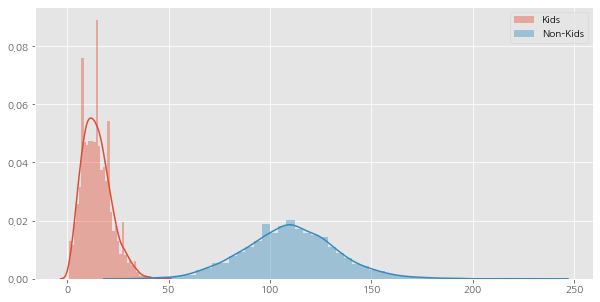

In [4]:
# 하루당 교통사고 건수의 분포
# 어린이, 비어린이 모두 노말함
plt.figure(figsize=(10,5))
sns.distplot(data[data.kids_acdnt==1].groupby("acdnt_dd_dc").size())
sns.distplot(data[data.kids_acdnt!=1].groupby("acdnt_dd_dc").size())
plt.legend(["Kids", "Non-Kids"])

# 2. 시계열 분석

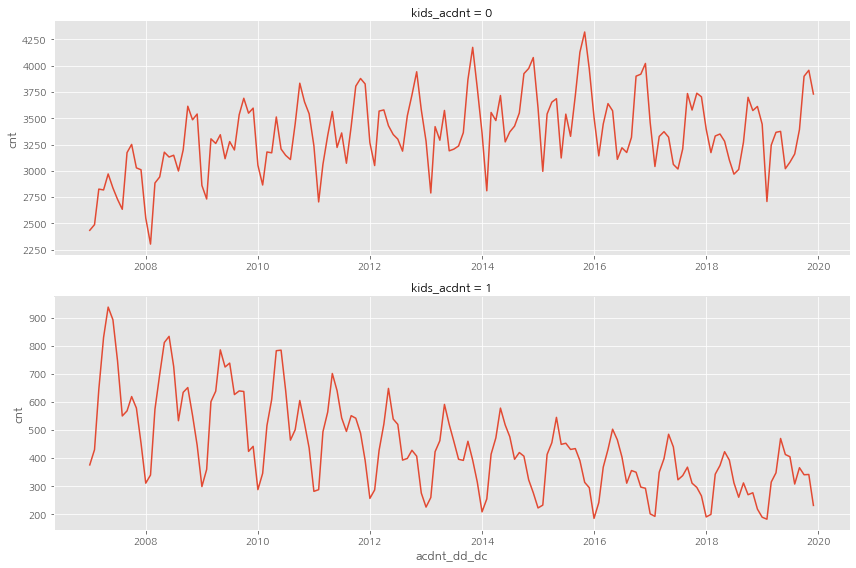

In [5]:
# 위쪽은 월별 비어린이 교통사고 사고
# 아래쪽은 월별어린이 교통사고(1세~14세): 연간 계절성과 감소 추세가 뚜렷하게 나타남
ts_data = data.groupby([
    "kids_acdnt", (data.acdnt_dd_dc.dt.strftime("%Y-%m") + "-01").astype("datetime64")]
).size().reset_index().rename(columns={0:"cnt"})
sns.FacetGrid(
    ts_data,
    row = "kids_acdnt",
    sharex=False,
    sharey=False,
    height=4,
    aspect=3).map(sns.lineplot, "acdnt_dd_dc", "cnt")

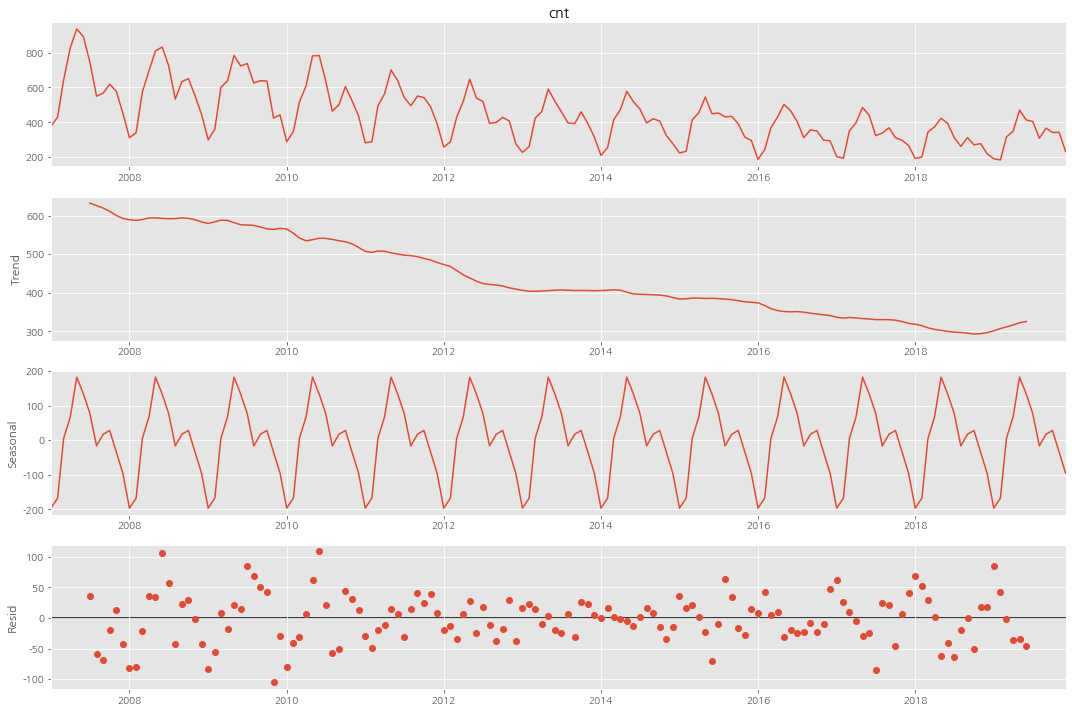

In [10]:
# 시계열 성분 분해: Trend + Seasonality + Residuals
plt.rcParams["figure.figsize"] = (15,10)
res = seasonal_decompose(
    ts_data[ts_data.kids_acdnt.astype(bool)].set_index("acdnt_dd_dc").cnt,
    model="additive"
)
res.plot();plt.show();

NormaltestResult(statistic=0.574663257422327, pvalue=0.7502628788648991)


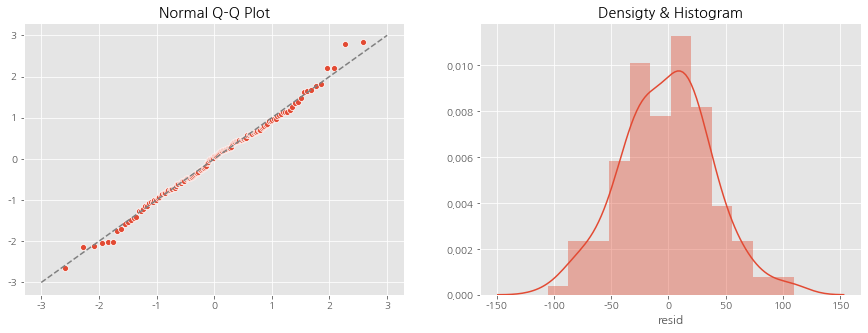

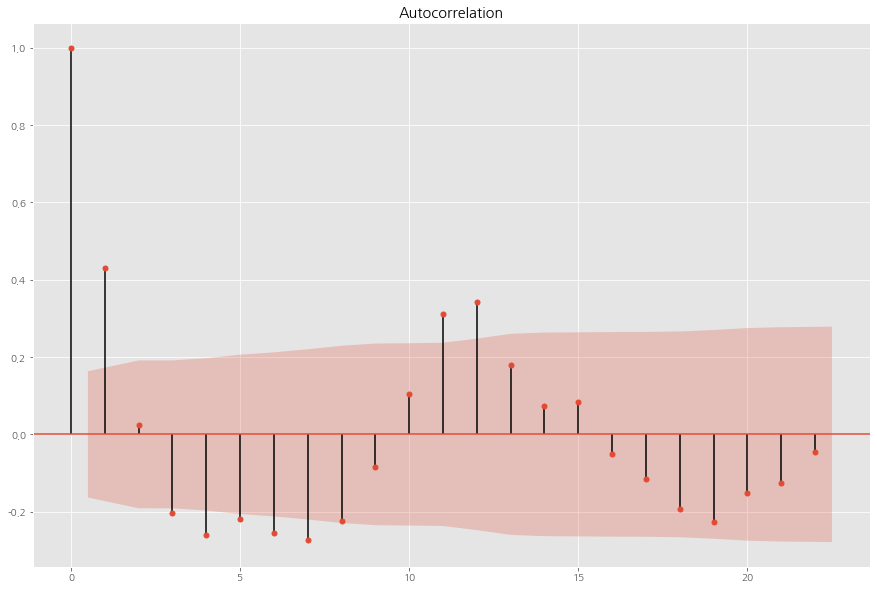

In [11]:
# 잔차 진단
residual = res.resid[~res.resid.isna()]
sr = stats.zscore(residual)
(x, y), _ = stats.probplot(sr)

# Q-Q plot
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("Normal Q-Q Plot")
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color='grey')

# Density & Histogram
plt.subplot(1,2,2)
plt.title("Densigty & Histogram")
sns.distplot(residual)

# 정규성 검정
print(stats.normaltest(residual))

# Autocorrelation
plot_acf(residual); plt.show();

# 3. 사고 발생 시간대

In [12]:
kids = data[data.victim_age_group.isin(["0대","10대"])]
kidszone = kids[kids.kidszone.astype(bool)]
nonkidszone = kids[~kids.kidszone.astype(bool)]

Text(0.5, 1.0, 'Kidszone')

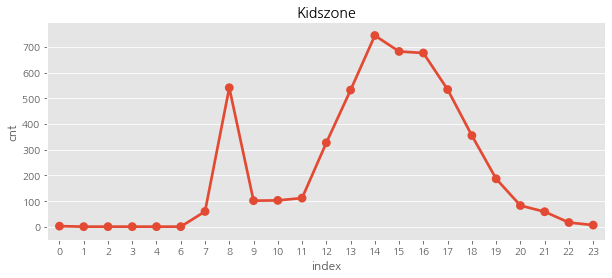

In [15]:
plt.figure(figsize=(10,4))
sns.pointplot(
    data=kidszone.occrrnc_time_dc.value_counts().rename("cnt").reset_index(),
    x="index",
    y="cnt"
)
plt.title("Kidszone")

Text(0.5, 1.0, 'Non-kidszone')

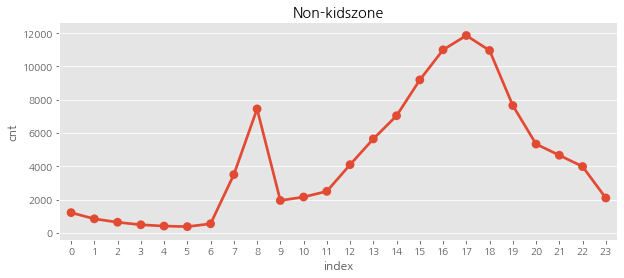

In [16]:
plt.figure(figsize=(10,4))
sns.pointplot(
    data=nonkidszone.occrrnc_time_dc.value_counts().rename("cnt").reset_index(),
    x="index",
    y="cnt"
)
plt.title("Non-kidszone")

In [ ]:
tmp = data.groupby(['occrrnc_time_dc','acdnt_dd_dc','victim_age_group']).size().reset_index().rename(columns={0:"cnt"})\
    .groupby(["occrrnc_time_dc", 'victim_age_group']).cnt.mean().rename("cnt").reset_index()\
    .pivot("occrrnc_time_dc", "victim_age_group", "cnt")
fig = go.Figure()
for age in tmp.columns:
    if age in ["0대", "10대"]:
        width, opacity = 2, 1
    else:
        width, opacity = 1, 0.3
    fig.add_trace(
         go.Scatter(
            x=tmp.index.values,
            y=tmp[age].values,
            mode='lines+markers',
            name= age,
            line=dict(width=width),
            opacity=opacity
         )
    )
fig

# 4. 기타 범주형 변수들

In [18]:
kids = data[data.kids_acdnt==1].drop("kids_acdnt",axis=1)
kids = kids.assign(sido = [x.split()[0] for x in kids.legaldong_name])

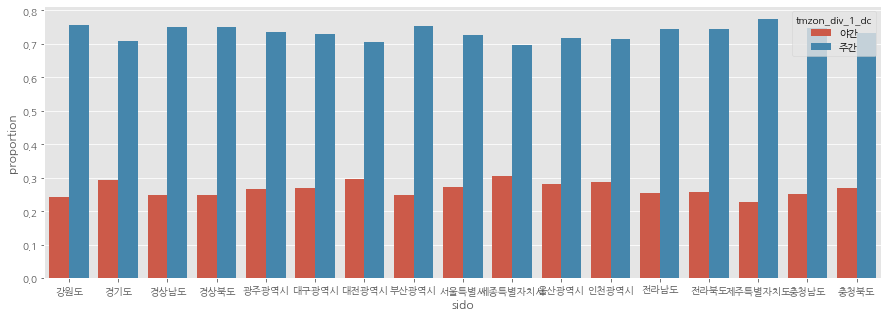

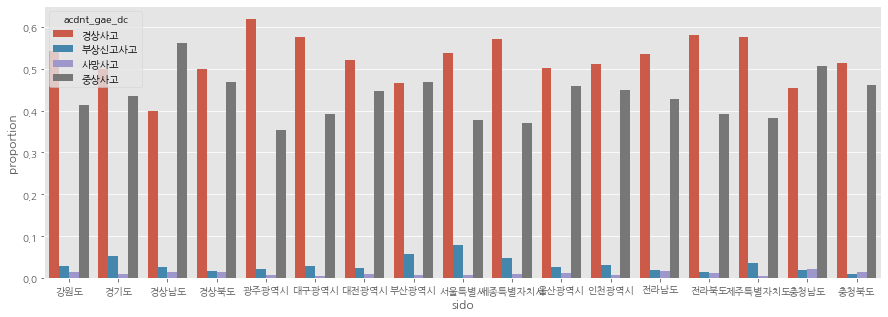

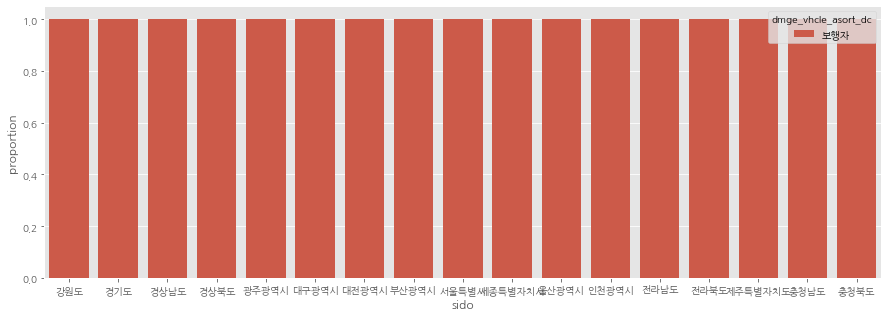

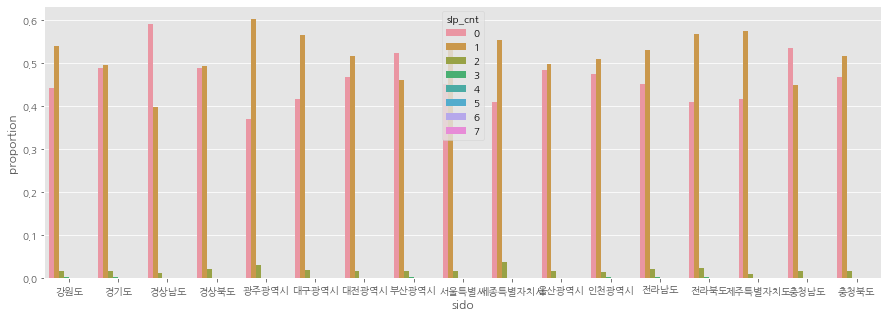

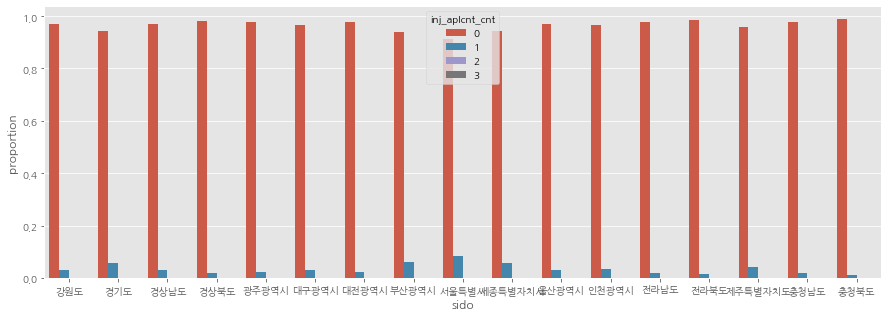

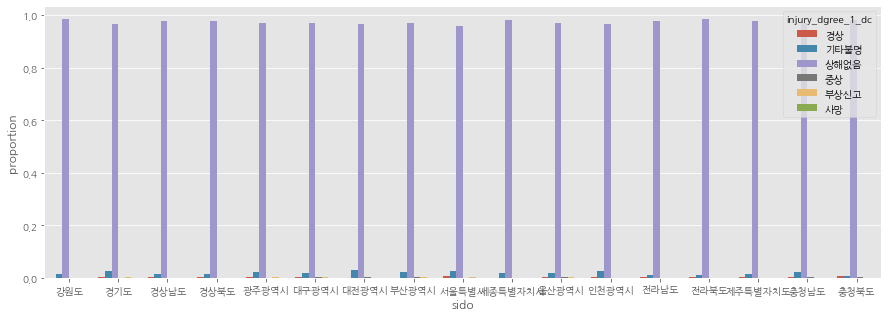

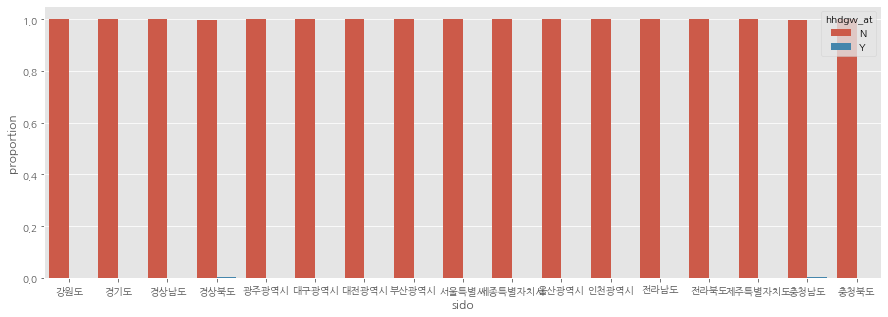

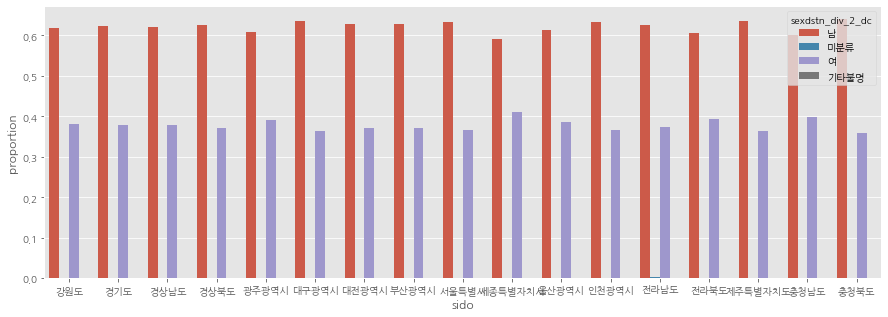

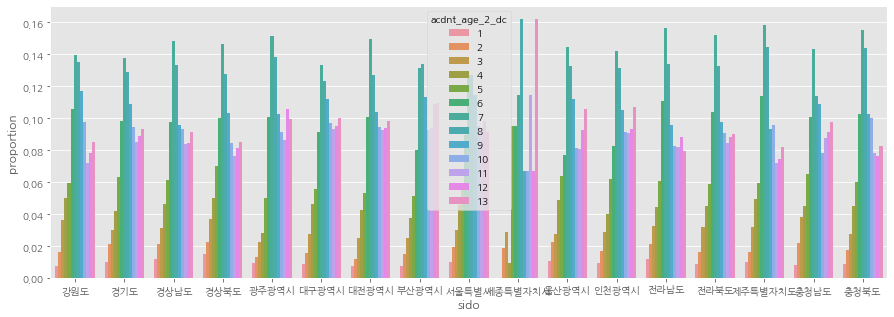

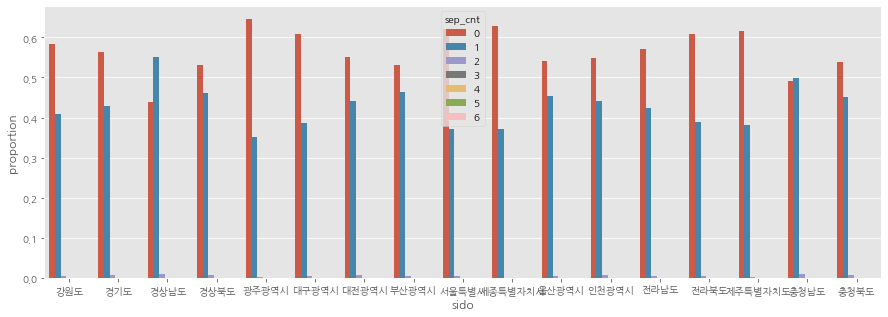

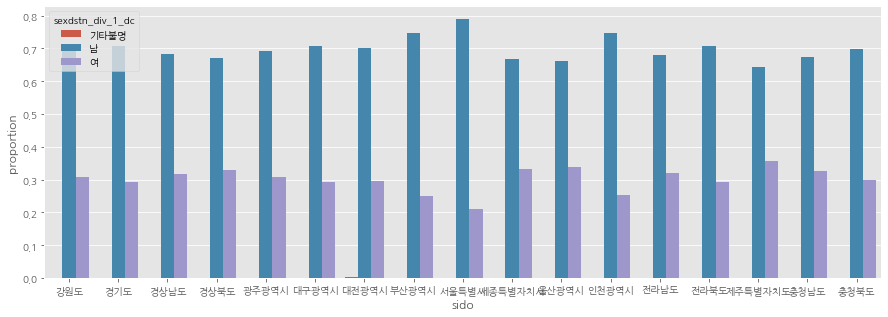

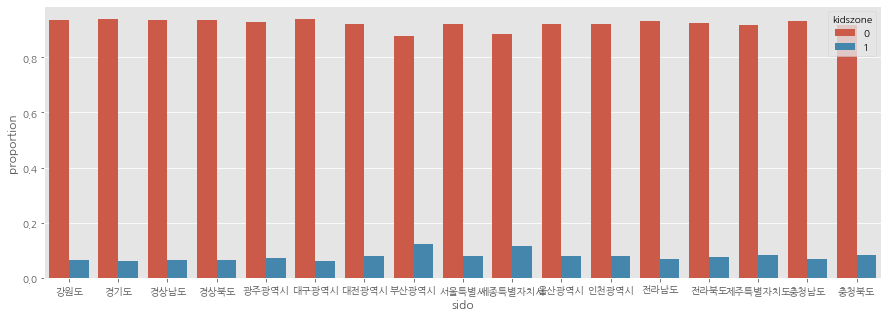

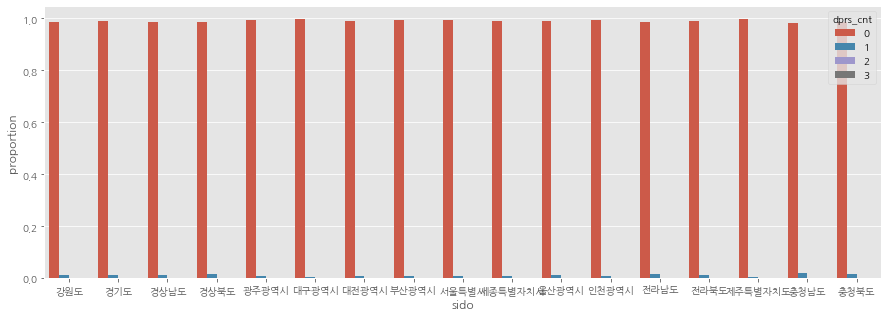

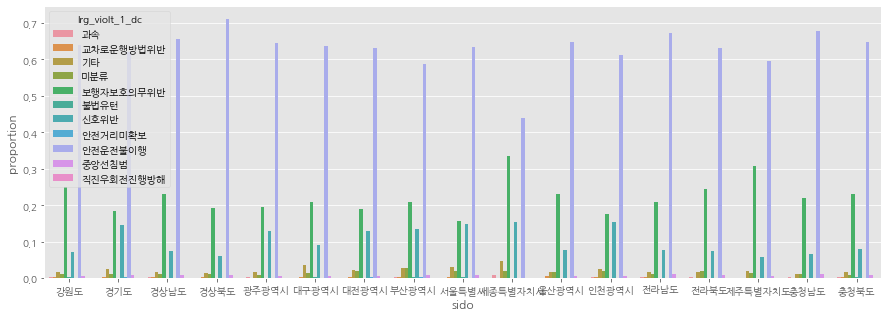

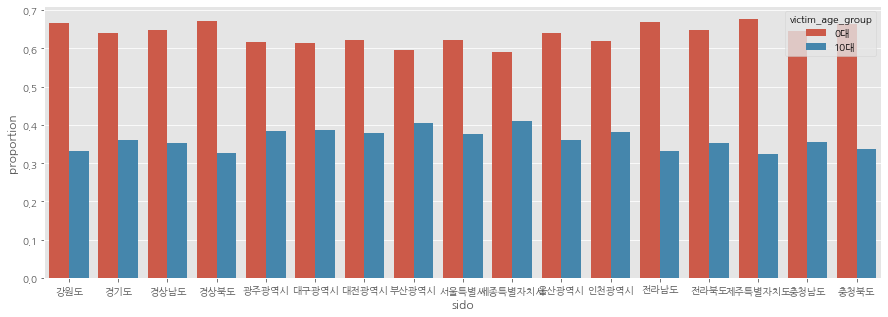

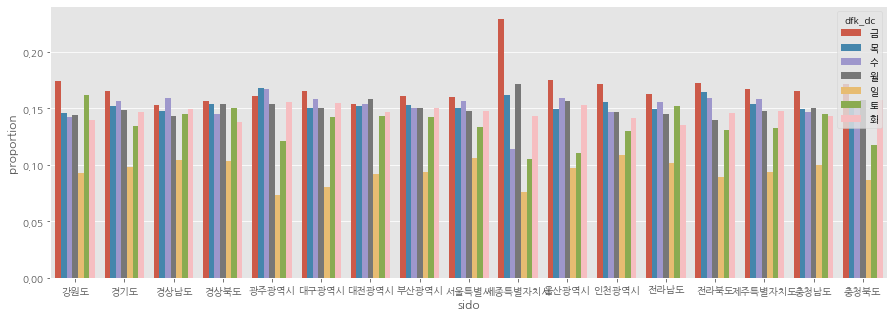

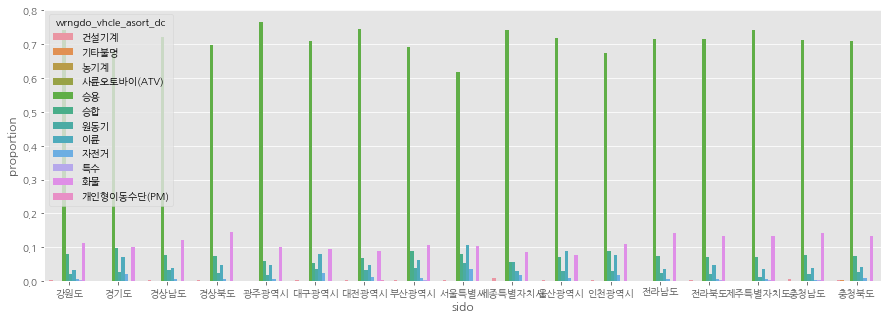

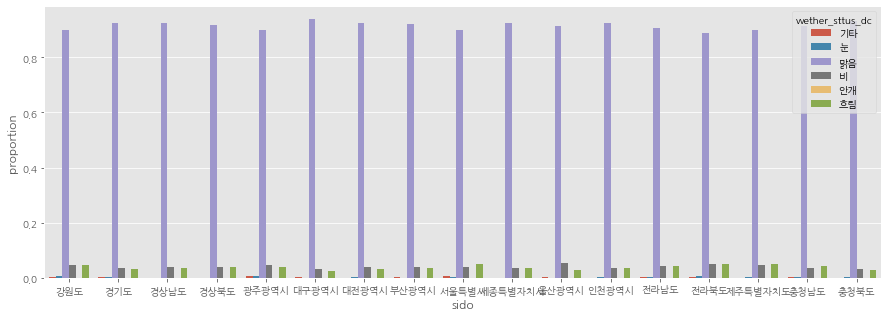

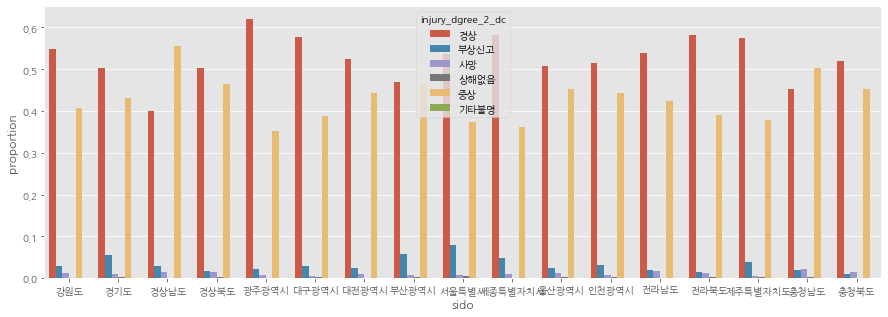

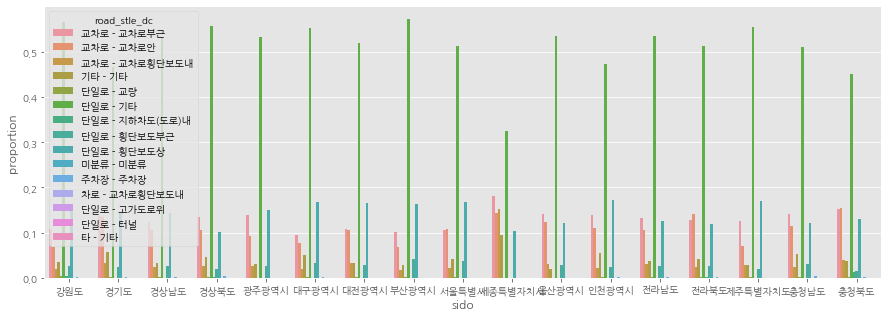

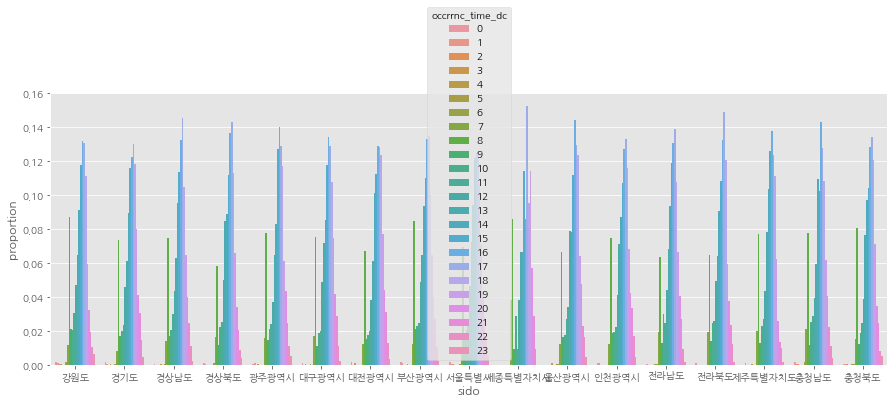

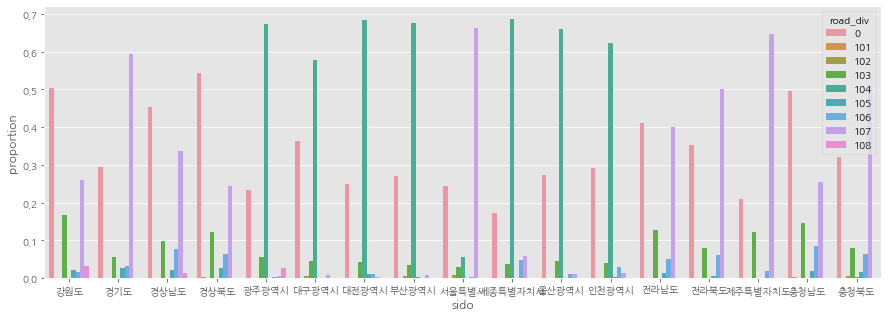

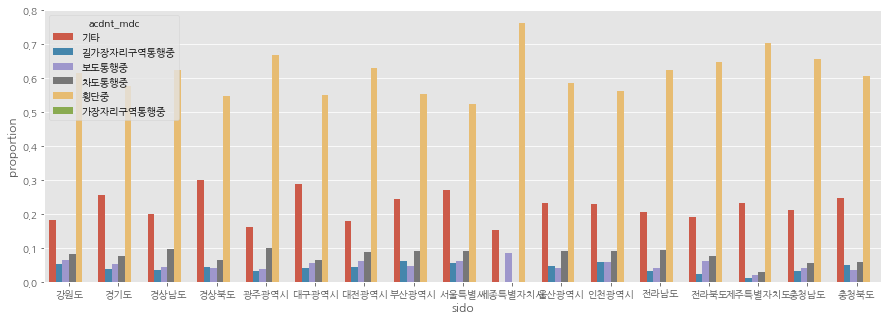

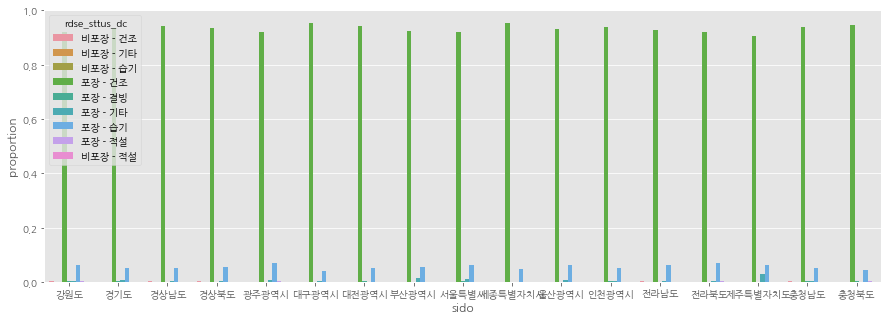

In [20]:
for colname in list(set(kids.columns.values) - {"sido"}):
    uniques = kids[colname].unique()
    if uniques.size < 30:
        result = (kids.groupby(["sido",colname, "acdnt_dd_dc"])
                      .size()
                      .rename("cnt")
                      .reset_index()
                      .groupby(["sido",colname]).cnt.sum()
                      .reset_index()
                      .rename(columns={0:"cnt"})
                 ).fillna(0)
        result = result.groupby("sido").apply(lambda x: x.assign(proportion = x.cnt/x.cnt.sum())).reset_index(drop=True)
        plt.figure(figsize=(15,5))
        sns.barplot(
            data=result,
            y="proportion",
            x="sido",
            hue=colname
        )
        plt.show()

kids_acdnt           0      1
tmzon_div_1_dc               
야간              266393  18564
주간              256047  50602


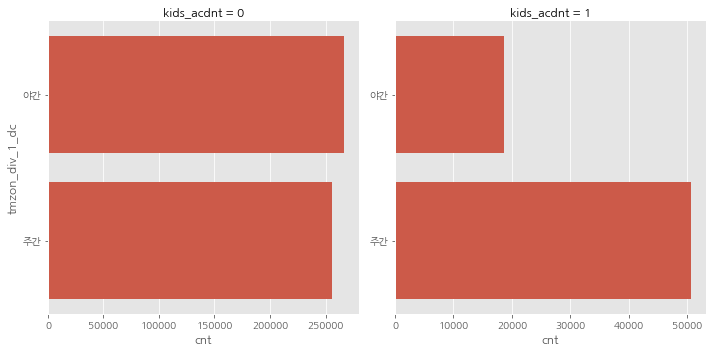

kids_acdnt         0      1
acdnt_gae_dc               
경상사고          224808  35613
부상신고사고         17019   2807
사망사고           22672    720
중상사고          257941  30026


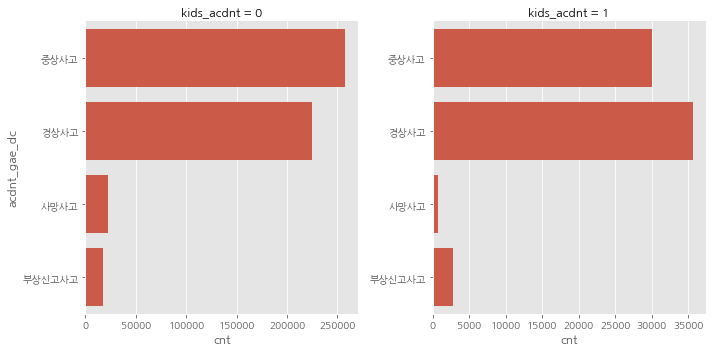

kids_acdnt                  0        1
dmge_vhcle_asort_dc                   
보행자                  522431.0  69166.0
승용                        7.0      NaN
승합                        1.0      NaN
화물                        1.0      NaN


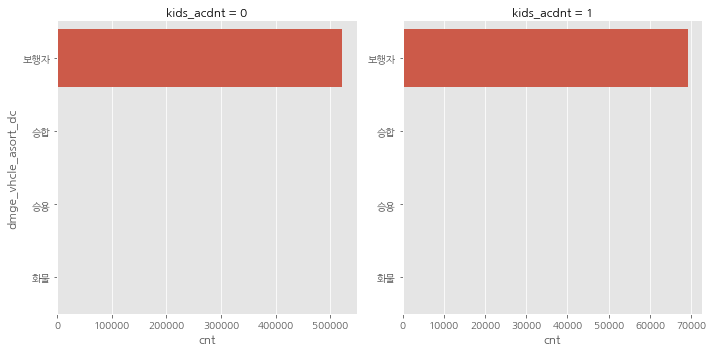

kids_acdnt         0        1
slp_cnt                      
0           287508.0  32672.0
1           224204.0  35216.0
2             9363.0   1177.0
3              979.0     81.0
4              228.0      9.0
5               87.0      6.0
6               26.0      4.0
7               21.0      1.0
8                5.0      NaN
9                7.0      NaN
10               2.0      NaN
11               3.0      NaN
12               1.0      NaN
13               1.0      NaN
14               1.0      NaN
18               1.0      NaN
19               2.0      NaN
22               1.0      NaN


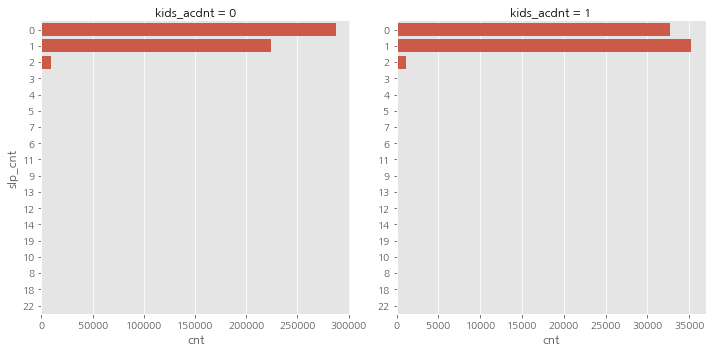

kids_acdnt             0        1
inj_aplcnt_cnt                   
0               502903.0  66095.0
1                18986.0   3008.0
2                  487.0     57.0
3                   48.0      6.0
4                    9.0      NaN
5                    7.0      NaN


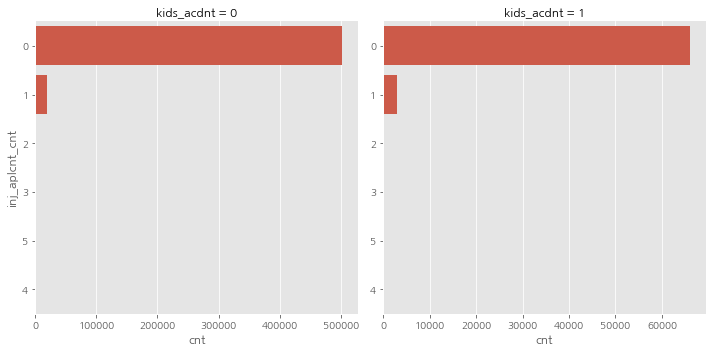

kids_acdnt              0      1
injury_dgree_1_dc               
경상                   2870    278
기타불명                13481   1483
부상신고                 1670    175
사망                     93      6
상해없음               502809  67107
중상                   1517    117


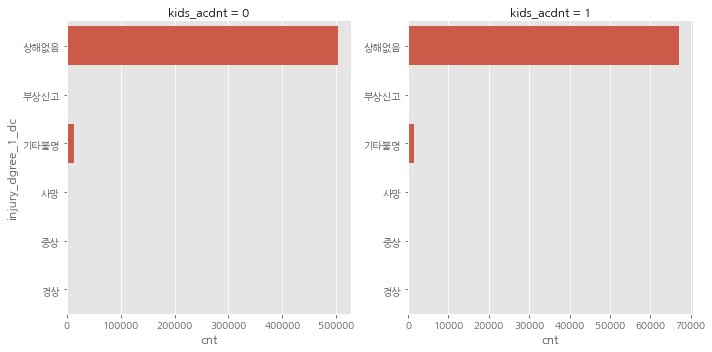

kids_acdnt       0      1
hhdgw_at                 
N           521312  69126
Y             1128     40


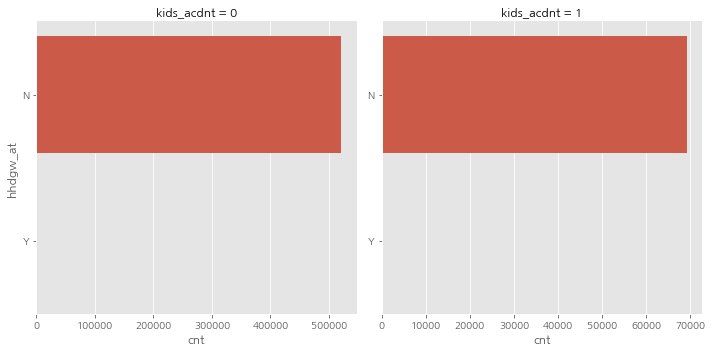

kids_acdnt             0      1
sexdstn_div_2_dc               
기타불명                   8      1
남                 262347  43215
미분류                   13     28
여                 260072  25922


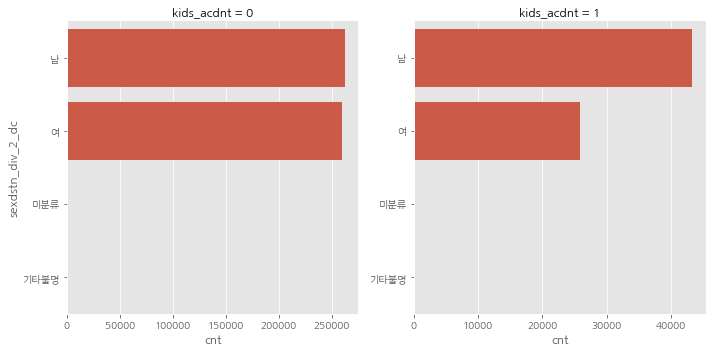

kids_acdnt         0        1
sep_cnt                      
0           263455.0  39111.0
1           251778.0  29597.0
2             6526.0    431.0
3              507.0     21.0
4              102.0      3.0
5               43.0      2.0
6               11.0      1.0
7                7.0      NaN
8                5.0      NaN
9                1.0      NaN
10               1.0      NaN
11               3.0      NaN
13               1.0      NaN


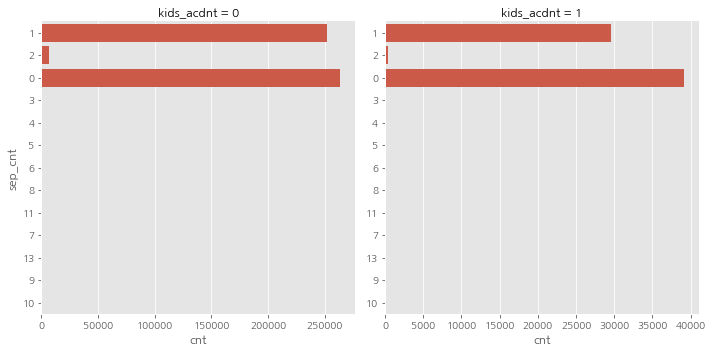

kids_acdnt             0      1
sexdstn_div_1_dc               
기타불명                 403     56
남                 417023  49361
여                 105014  19749


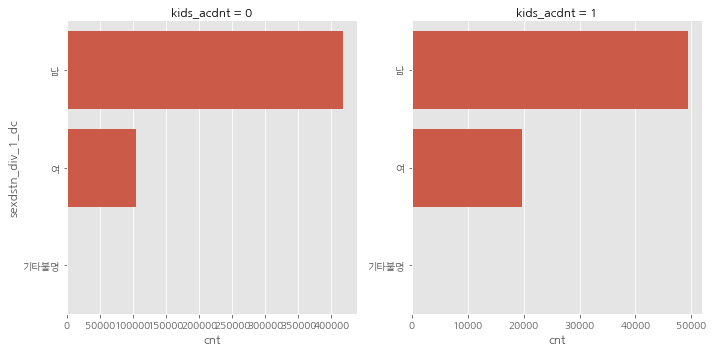

kids_acdnt       0      1
kidszone                 
0           522384  64042
1               56   5124


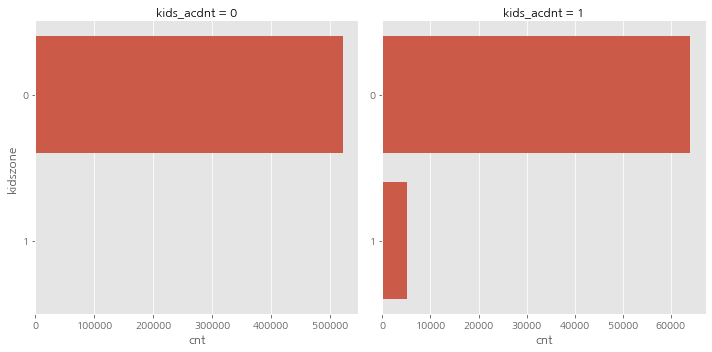

kids_acdnt         0        1
dprs_cnt                     
0           499768.0  68446.0
1            22445.0    714.0
2              212.0      5.0
3               12.0      1.0
4                2.0      NaN
5                1.0      NaN


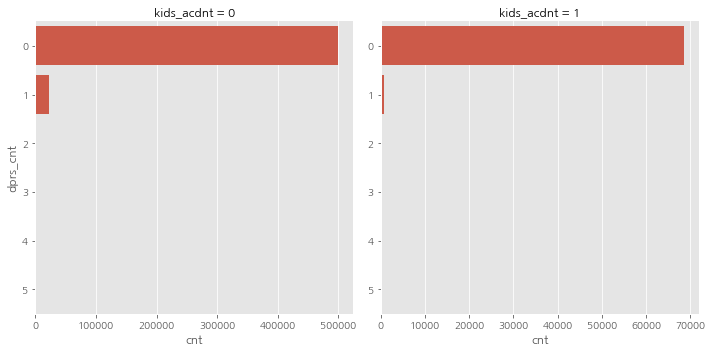

kids_acdnt             0        1
lrg_violt_1_dc                   
과속                2141.0    117.0
교차로운행방법위반         2673.0    179.0
기타               20453.0   1555.0
미분류                 42.0   1013.0
보행자보호의무위반        72524.0  13855.0
불법유턴              3179.0     85.0
신호위반             37265.0   7745.0
안전거리미확보            676.0     80.0
안전운전불이행         376662.0  44017.0
중앙선침범             6647.0    509.0
직진우회전진행방해          148.0     11.0
차로위반                30.0      NaN


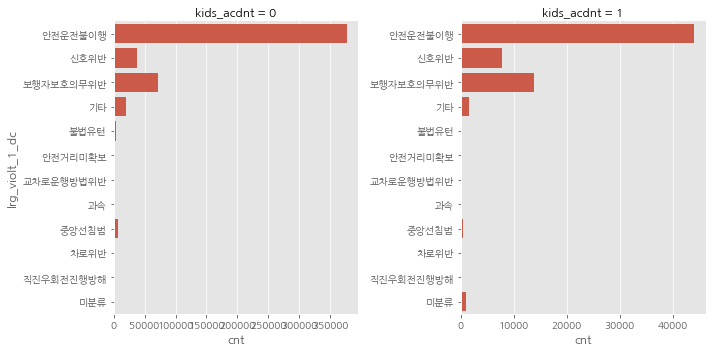

kids_acdnt              0        1
victim_age_group                  
0대                    NaN  44073.0
10대               41559.0  25093.0
20대               72722.0      NaN
30대               62512.0      NaN
40대               83912.0      NaN
50대               97571.0      NaN
60대               76256.0      NaN
70대               62900.0      NaN
80대               22832.0      NaN
90대                2176.0      NaN


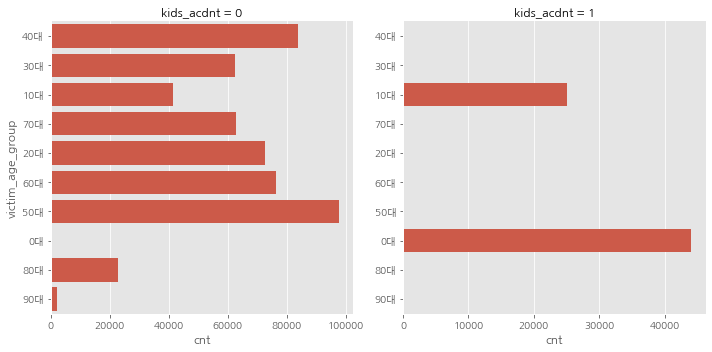

kids_acdnt      0      1
dfk_dc                  
금           83180  11304
목           77015  10542
수           77264  10694
월           76371  10277
일           56796   6710
토           75803   9485
화           76011  10154


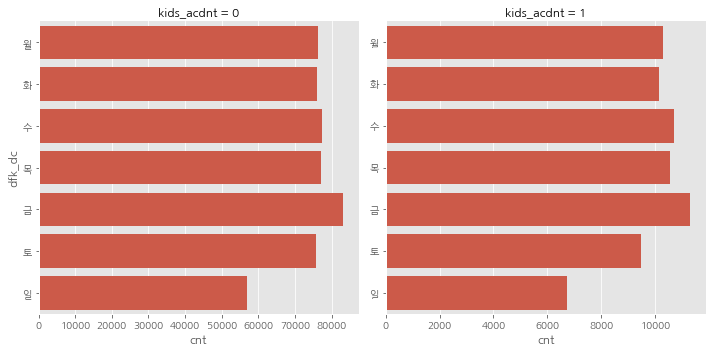

kids_acdnt                  0      1
wrngdo_vhcle_asort_dc               
개인형이동수단(PM)               193     25
건설기계                     2800    142
기타불명                      509     51
농기계                       288     12
사륜오토바이(ATV)                73      4
승용                     355521  47799
승합                      46436   5544
원동기                     12479   2183
이륜                      26735   4472
자전거                      9044   1099
특수                       1490     89
화물                      66872   7746


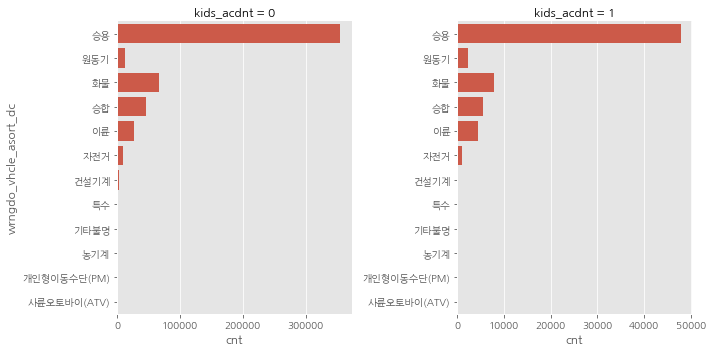

kids_acdnt            0      1
wether_sttus_dc               
기타                 3516    278
눈                  3328    206
맑음               445468  63245
비                 44622   2738
안개                  642     18
흐림                24864   2681


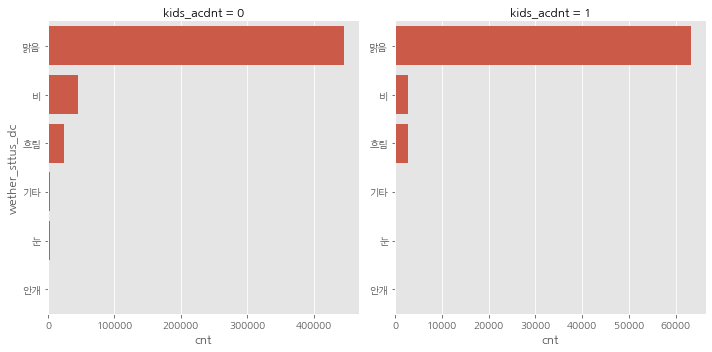

kids_acdnt              0      1
injury_dgree_2_dc               
경상                 226457  35762
기타불명                   24      3
부상신고                17004   2835
사망                  22437    712
상해없음                 1342    157
중상                 255176  29697


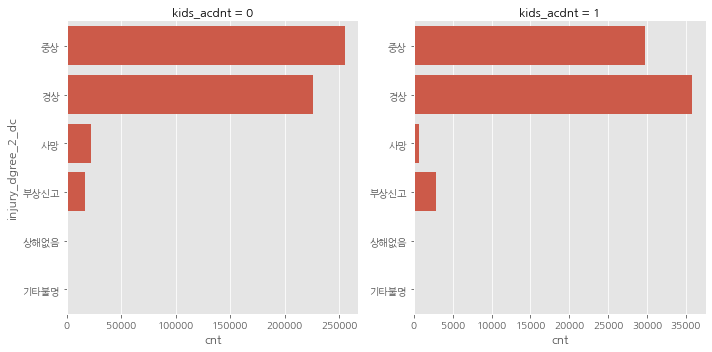

kids_acdnt              0        1
road_stle_dc                      
교차로 - 교차로부근       71685.0   8609.0
교차로 - 교차로안        72183.0   7600.0
교차로 - 교차로횡단보도내    14454.0   1840.0
기타 - 기타           26079.0   3005.0
단일로 - 고가도로위          94.0      2.0
단일로 - 교량           1665.0    167.0
단일로 - 기타         272019.0  35539.0
단일로 - 지하차도(도로)내     805.0     82.0
단일로 - 터널            176.0      7.0
단일로 - 횡단보도부근      11287.0   1957.0
단일로 - 횡단보도상       50162.0  10221.0
미분류 - 미분류           317.0     21.0
일로 - 교량               1.0      NaN
일로 - 지하차도(도로)내        1.0      NaN
일로 - 횡단보도부근           4.0      NaN
주차장 - 주차장          1493.0    114.0
차로 - 교차로횡단보도내         7.0      1.0
타 - 기타                8.0      1.0


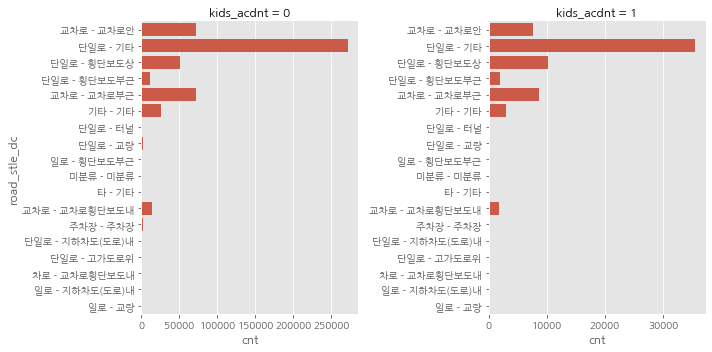

kids_acdnt           0     1
occrrnc_time_dc             
0                19365    92
1                14188    35
2                10363    24
3                 7608    11
4                 8099    15
5                10267    14
6                12799    34
7                15877   898
8                22747  5039
9                20785  1119
10               20924  1476
11               20664  1711
12               21233  3111
13               21703  4705
14               22519  6359
15               24011  7983
16               24799  8986
17               27986  9181
18               38688  7765
19               36342  4822
20               34165  2771
21               32438  1848
22               29687   879
23               25183   288


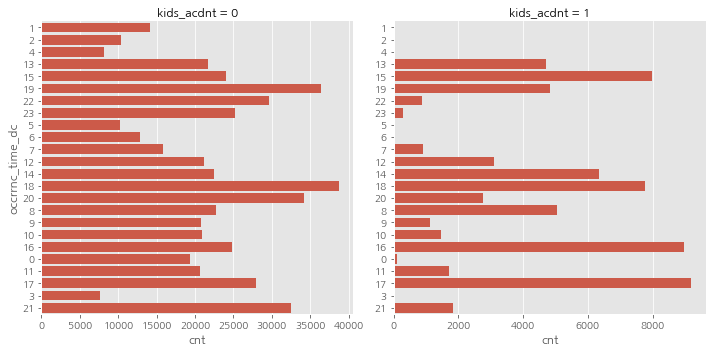

kids_acdnt       0      1
road_div                 
0           133704  23057
101            917     27
102           2413    160
103          65339   4796
104         105614  12403
105           7693    874
106          17541   2093
107         187528  25529
108           1691    227


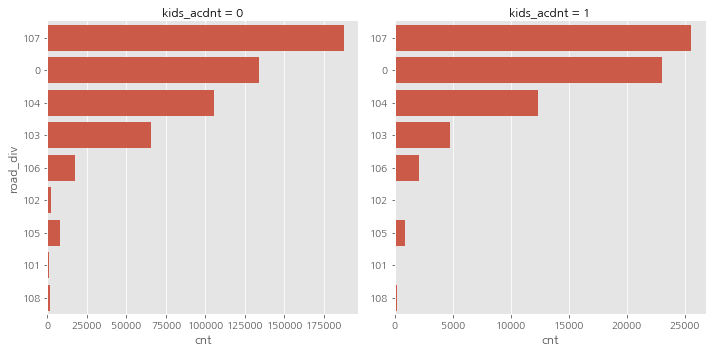

kids_acdnt       0      1
acdnt_mdc                
가장자리구역통행중        2      1
기타          175589  16544
길가장자리구역통행중   42177   2950
보도통행중        26747   3545
차도통행중        52840   5578
횡단중         225085  40548


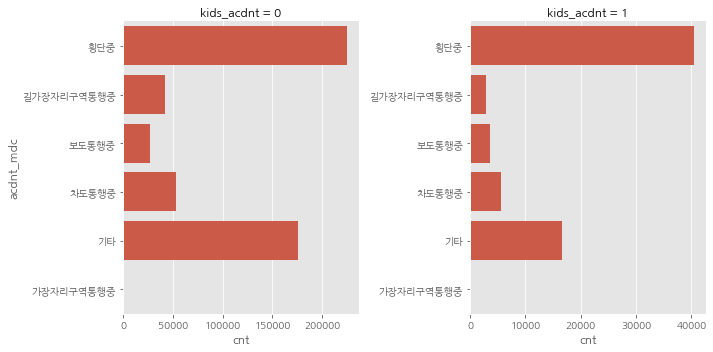

kids_acdnt            0        1
rdse_sttus_dc                   
비포장 - 건조          990.0    102.0
비포장 - 결빙           18.0      NaN
비포장 - 기타          216.0     22.0
비포장 - 서리/결빙         5.0      NaN
비포장 - 습기          301.0     16.0
비포장 - 적설           24.0      5.0
장 - 젖음/습기           2.0      NaN
포장 - 건조        453743.0  64430.0
포장 - 결빙          2525.0    130.0
포장 - 기타          4685.0    480.0
포장 - 습기         58303.0   3874.0
포장 - 적설          1618.0    107.0
포장 - 침수             8.0      NaN
포장 - 해빙             2.0      NaN


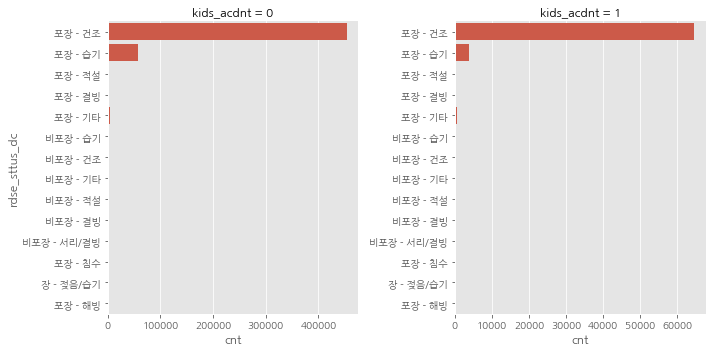

In [21]:
for colname in list(set(data.columns.values) - {"kids_acdnt"}):
    uniques = data[colname].unique()
    if uniques.size < 30:
        result = (data.groupby(["kids_acdnt",colname, "acdnt_dd_dc"])
                      .size()
                      .reset_index()
                      .rename(columns={0:"cnt"})
                      .groupby(["kids_acdnt",colname]).cnt.sum()
                      .reset_index()
                      .rename(columns={0:"cnt"})
                 )
        result = result.groupby("kids_acdnt").apply(lambda x: x.assign(proportion = x.cnt/x.cnt.sum())).reset_index(drop=True)
        print("========================")
        print(result.pivot(colname, "kids_acdnt", "cnt"))
        print("========================")
        sns.FacetGrid(
            result,
            col = "kids_acdnt",
            sharex=False,
            sharey=False,
            height=5,
            aspect=1
        ).map(sns.barplot, "cnt", colname, orient="h", order=uniques)
        plt.show()